## Packages

In [1]:
import cv2
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

## Load and Preprocess Data

In [2]:
class HOIDataset(Dataset):
    def __init__(self, transform, data_list, label_list):
        self.imgs_path = "vcoco_dataset/"
        self.transform = transform
        self.data = []
        for i in range(len(data_list)):
            img_path = data_list[i]
            class_name = label_list[i]
            agent_path = img_path + '/agent.jpg'
            object_path = img_path + '/object.jpg'
            union_path = img_path + '/union.jpg'
            self.data.append([agent_path, object_path, union_path, class_name])

        self.class_map = {
            'sit': 0,
            'ride': 1,
            'jump': 2,
            'lay': 3,
            'talk_on_phone': 4,
            'carry': 5,
            'throw': 6,
            'catch': 7,
            'work_on_computer': 8,
            'surf': 9,
            'skateboard': 10,
            'ski': 11,
            'snowboard': 12,
            'drink': 13,
            'kick': 14,
            'point': 15,
            'read': 16,
            'hold': 17,
            'look': 18
        }
    
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self, idx):
        agent_path, object_path, union_path, class_name = self.data[idx]
        agent_img = Image.open(agent_path)
        object_img = Image.open(object_path)
        union_img = Image.open(union_path)
        
        if self.transform:
            agent_img = self.transform(agent_img)
            object_img = self.transform(object_img)
            union_img = self.transform(union_img)

        trans = transforms.Compose([ 
            transforms.ToTensor() 
        ]) 
        agent = trans(agent_img)
        object = trans(object_img)
        union = trans(union_img)
        class_id = self.class_map[class_name]
        one_hot_class = torch.Tensor([0] * 13)
        one_hot_class[class_id] += 1
        
        return agent, object, union, one_hot_class

In [3]:
class PadToSquare:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - h) // 2
        wp = (max_wh - w) // 2
        padding = (wp, hp, wp, hp)
        return transforms.functional.pad(image, padding, fill=0, padding_mode='constant')
    
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        return transforms.functional.resize(image, self.output_size)

class PadAndRescale:
    def __init__(self, output_size):
        self.pad = PadToSquare()
        self.rescale = Rescale(output_size)

    def __call__(self, image):
        image = self.pad(image)
        image = self.rescale(image)
        return image


In [4]:
data_list = []
label_list = []
imgs_path = "vcoco_dataset/"
file_list = glob.glob(imgs_path + "*")
for class_path in file_list:
    class_name = class_path.split("/")[-1]
    if len(glob.glob(class_path + "/*")) < 300:
        continue
    elif class_name == 'hold' or class_name == 'look':
        continue
    num_img = 0
    for img_path in glob.glob(class_path + "/*"):
        data_list.append(img_path)
        label_list.append(class_name)
        num_img += 1
        if num_img > 417:
            break

# Split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data_list, label_list, test_size=0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=(1/9), random_state=42)

# Create HOIDatasets
transform = PadAndRescale(output_size=(128, 128))
train_dataset = HOIDataset(transform = transform, data_list = train_data, label_list = train_labels)
test_dataset = HOIDataset(transform = transform, data_list = test_data, label_list = test_labels)
val_dataset = HOIDataset(transform = transform, data_list = val_data, label_list = val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

convlayers = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
    nn.BatchNorm2d(96),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),

    nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),

    nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(384),
    nn.ReLU(),
    
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2),
    nn.BatchNorm2d(384),
    nn.ReLU(),
    
    nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2),
    nn.BatchNorm2d(256),
    nn.ReLU()
)

### Human Stream

import copy
hs_model = copy.deepcopy(convlayers)
hs_model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
hs_model.append(nn.Flatten())
hs_model.append(nn.Linear(256 * 4 * 4, 4096))
hs_model.append(nn.ReLU())
hs_model.append(nn.Dropout(p=0.5))
hs_model.append(nn.Linear(4096, 600))
hs_model.append(nn.ReLU())
hs_model.append(nn.Dropout(p=0.5))
hs_model.append(nn.Linear(600, 13))
hs_model.append(nn.Sigmoid())

### Object Stream

os_model = copy.deepcopy(convlayers)
os_model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
os_model.append(nn.Flatten())
os_model.append(nn.Linear(256 * 4 * 4, 4096))
os_model.append(nn.ReLU())
os_model.append(nn.Dropout(p=0.5))
os_model.append(nn.Linear(4096, 600))
os_model.append(nn.ReLU())
os_model.append(nn.Dropout(p=0.5))
os_model.append(nn.Linear(600, 13))
os_model.append(nn.Sigmoid())

### Pairwise Stream

'''
ps_model = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=5),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(96, 64, kernel_size=5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(64, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(5408, 600),
    nn.ReLU(),
    nn.Linear(600, 13),
    nn.Sigmoid()
)
'''
ps_model = copy.deepcopy(convlayers)
ps_model.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
ps_model.append(nn.Flatten())
ps_model.append(nn.Linear(256 * 4 * 4, 4096))
ps_model.append(nn.ReLU())
ps_model.append(nn.Dropout(p=0.5))
ps_model.append(nn.Linear(4096, 600))
ps_model.append(nn.ReLU())
ps_model.append(nn.Dropout(p=0.5))
ps_model.append(nn.Linear(600, 13))
ps_model.append(nn.Sigmoid())

## Training

### Hyperparameters

num_epochs = 80

criterion = nn.CrossEntropyLoss()
h_optimizer = optim.Adam(hs_model.parameters(), lr=0.0001)
o_optimizer = optim.Adam(os_model.parameters(), lr=0.0001)
p_optimizer = optim.Adam(ps_model.parameters(), lr=0.0001)

for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}')):
        
        h_input, o_input, p_input, y = data
        
        h_optimizer.zero_grad()
        o_optimizer.zero_grad()
        p_optimizer.zero_grad()

        h_yhat = hs_model(h_input)
        o_yhat = os_model(o_input)
        p_yhat = ps_model(p_input)

        yhat = (h_yhat + o_yhat + p_yhat) / 3.0
        
        loss = criterion(yhat, y)
        loss.backward()
        h_optimizer.step()
        o_optimizer.step()
        p_optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
    val_loss = 0.0
    val_steps = 0
    hs_model.eval()
    os_model.eval()
    ps_model.eval()
    
    with torch.no_grad():
        correct = 0
        wrong = 0
        action_real = [0] * 13
        action_predict = [0] * 13
        for val_data in tqdm(test_loader, desc=f'Validation Epoch {epoch + 1}'):
            h_input, o_input, p_input, y = val_data
            
            h_yhat = hs_model(h_input)
            o_yhat = os_model(o_input)
            p_yhat = ps_model(p_input)

            y_hat = (h_yhat + o_yhat + p_yhat) / 3.0

            predicted = torch.argmax(y_hat.data, 1)
            action_predict[predicted] += 1

            true_labels = torch.argmax(y, 1)
            action_real[true_labels] += 1

            for i in range(len(true_labels)):
                if predicted==true_labels:
                    correct += 1
                else:
                    wrong += 1
            loss = criterion(y_hat, y)
            val_loss += loss.item()
            val_steps += 1

    avg_val_loss = val_loss / val_steps
    accuracy = correct / (correct + wrong)
    print(f'Epoch {epoch + 1} | validation loss: {avg_val_loss:.3f} | accuracy: {accuracy}')
    print(action_real)
    print(action_predict)

# Load the saved weights
PATH = './hs_model_weights.pth'
hs_model.load_state_dict(torch.load(PATH))
hs_model.eval()

PATH = './os_model_weights.pth'
os_model.load_state_dict(torch.load(PATH))
os_model.eval()

PATH = './ps_model_weights.pth'
ps_model.load_state_dict(torch.load(PATH))
ps_model.eval()

## Evaluation

correct = 0
wrong = 0
count = 0

for i, data in enumerate(test_loader):
    
    h_input, o_input, p_input, y = data
    
    h_yhat = hs_model(h_input)
    o_yhat = os_model(o_input)
    p_yhat = ps_model(p_input)
    
    yhat = (h_yhat + o_yhat + p_yhat) / 3.0
    
    # Get the predicted class for each input in the batch
    predicted = torch.argmax(yhat.data, 1)

    # Get the correct class indices
    true_labels = torch.argmax(y, 1)

    if predicted==true_labels:
        correct += 1
    else:
        wrong += 1

accuracy = correct / (correct + wrong)
print(f"correct: {correct}, wrong: {wrong}, accuracy: {accuracy}")
        

In [5]:
from torchvision import models
net = models.alexnet(pretrained=True)

net.classifier[6] = nn.Linear(in_features=4096, out_features=13, bias=True)

net.train()

/home/kale/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kale/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
import copy
hs_model = copy.deepcopy(net)
os_model = copy.deepcopy(net)
# ps_model = copy.deepcopy(net)
ps_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(64, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(5408, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 13),
    nn.Sigmoid()
)

In [7]:
num_epochs = 5

In [8]:
criterion = nn.CrossEntropyLoss()

h_optimizer = optim.Adam(hs_model.parameters(), lr=0.00005)
o_optimizer = optim.Adam(os_model.parameters(), lr=0.00005)
p_optimizer = optim.Adam(ps_model.parameters(), lr=0.0001)

In [9]:
for epoch in range(num_epochs): 

    running_loss = 0.0
    correct = 0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}')):
        
        h_input, o_input, p_input, y = data
        
        h_optimizer.zero_grad()
        o_optimizer.zero_grad()
        p_optimizer.zero_grad()

        h_yhat = hs_model(h_input)
        o_yhat = os_model(o_input)
        p_yhat = ps_model(p_input)

        yhat = (h_yhat + o_yhat + p_yhat) / 3.0
        
        loss = criterion(yhat, y)
        loss.backward()
        h_optimizer.step()
        o_optimizer.step()
        p_optimizer.step()

        correct += sum(torch.argmax(yhat, 1)==torch.argmax(y, 1)).item()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            print(f'Training accuracy: {correct / 3200}')
            correct = 0
            running_loss = 0.0
            
    val_loss = 0.0
    val_steps = 0
    hs_model.eval()
    os_model.eval()
    ps_model.eval()
    
    with torch.no_grad():
        correct = 0
        wrong = 0
        action_real = [0] * 13
        action_predict = [0] * 13
        for val_data in tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}'):
            h_input, o_input, p_input, y = val_data
            
            h_yhat = hs_model(h_input)
            o_yhat = os_model(o_input)
            p_yhat = ps_model(p_input)

            y_hat = (h_yhat + o_yhat + p_yhat) / 3.0

            predicted = torch.argmax(y_hat.data, 1)
            action_predict[predicted] += 1

            true_labels = torch.argmax(y, 1)
            action_real[true_labels] += 1

            for i in range(len(true_labels)):
                if predicted==true_labels:
                    correct += 1
                else:
                    wrong += 1
            loss = criterion(y_hat, y)
            val_loss += loss.item()
            val_steps += 1

    avg_val_loss = val_loss / val_steps
    accuracy = correct / (correct + wrong)
    print(f'Epoch {epoch + 1} | validation loss: {avg_val_loss:.3f} | accuracy: {accuracy}')
    print(action_real)
    print(action_predict)

Epoch 1:  74%|███████████████████████▌        | 100/136 [04:06<01:22,  2.28s/it]

[1,   100] loss: 1.606
Training accuracy: 0.4546875


Validation Epoch 1: 100%|█████████████████████| 544/544 [00:32<00:00, 16.60it/s]


Epoch 1 | validation loss: 1.152 | accuracy: 0.5735294117647058
[39, 42, 49, 37, 41, 36, 52, 37, 37, 47, 46, 36, 45]
[39, 62, 17, 24, 43, 32, 87, 12, 27, 55, 72, 62, 12]


Epoch 2:  74%|███████████████████████▌        | 100/136 [03:35<01:16,  2.13s/it]

[2,   100] loss: 0.815
Training accuracy: 0.693125


Validation Epoch 2: 100%|█████████████████████| 544/544 [00:30<00:00, 17.65it/s]


Epoch 2 | validation loss: 0.987 | accuracy: 0.6102941176470589
[39, 42, 49, 37, 41, 36, 52, 37, 37, 47, 46, 36, 45]
[14, 61, 27, 41, 43, 23, 62, 31, 42, 59, 55, 28, 58]


Epoch 3:  74%|███████████████████████▌        | 100/136 [04:41<01:47,  2.99s/it]

[3,   100] loss: 0.583
Training accuracy: 0.7715625


Validation Epoch 3: 100%|█████████████████████| 544/544 [00:49<00:00, 10.99it/s]


Epoch 3 | validation loss: 1.033 | accuracy: 0.5863970588235294
[39, 42, 49, 37, 41, 36, 52, 37, 37, 47, 46, 36, 45]
[40, 30, 51, 44, 37, 56, 38, 41, 31, 46, 44, 32, 54]


Epoch 4:  74%|███████████████████████▌        | 100/136 [05:31<02:09,  3.60s/it]

[4,   100] loss: 0.431
Training accuracy: 0.8315625


Validation Epoch 4: 100%|█████████████████████| 544/544 [00:45<00:00, 11.84it/s]


Epoch 4 | validation loss: 1.096 | accuracy: 0.5459558823529411
[39, 42, 49, 37, 41, 36, 52, 37, 37, 47, 46, 36, 45]
[66, 26, 63, 30, 41, 31, 37, 54, 29, 37, 51, 40, 39]


Epoch 5:  74%|███████████████████████▌        | 100/136 [03:52<01:13,  2.03s/it]

[5,   100] loss: 0.348
Training accuracy: 0.8665625


Validation Epoch 5: 100%|█████████████████████| 544/544 [00:28<00:00, 19.17it/s]

Epoch 5 | validation loss: 1.198 | accuracy: 0.5698529411764706
[39, 42, 49, 37, 41, 36, 52, 37, 37, 47, 46, 36, 45]
[57, 28, 49, 45, 37, 38, 82, 8, 30, 50, 50, 29, 41]


In [10]:
# save weights
PATH = './hs_model_weights.pth'
torch.save(hs_model.state_dict(), PATH)

PATH = './os_model_weights.pth'
torch.save(os_model.state_dict(), PATH)

PATH = './ps_model_weights.pth'
torch.save(ps_model.state_dict(), PATH)

In [11]:
# Load the saved weights
PATH = './hs_model_weights.pth'
hs_model.load_state_dict(torch.load(PATH))
hs_model.eval()

PATH = './os_model_weights.pth'
os_model.load_state_dict(torch.load(PATH))
os_model.eval()

PATH = './ps_model_weights.pth'
ps_model.load_state_dict(torch.load(PATH))
ps_model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=5408, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=512, bias=True)
  (18): Re

100%|█████████████████████████████████████████| 544/544 [00:28<00:00, 19.02it/s]


testing loss: 1.217 | accuracy: 0.5680147058823529


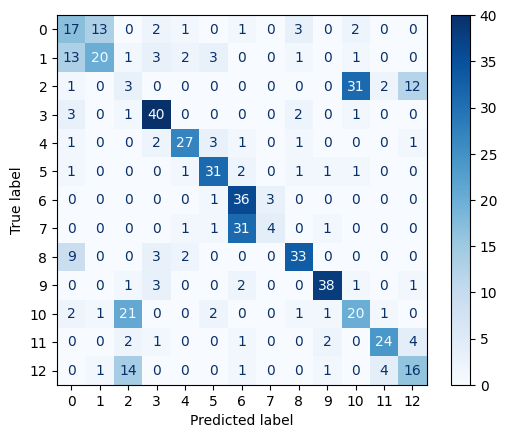

In [12]:
from sklearn import metrics

correct = 0
wrong = 0
action_real = [0] * 13
action_predict = [0] * 13
predictions = []
labels = []
test_loss = 0.0
test_steps = 0
for test_data in tqdm(test_loader):
    h_input, o_input, p_input, y = test_data
    
    h_yhat = hs_model(h_input)
    o_yhat = os_model(o_input)
    p_yhat = ps_model(p_input)

    y_hat = (h_yhat + o_yhat + p_yhat) / 3.0

    predicted = torch.argmax(y_hat.data, 1)
    action_predict[predicted] += 1
    predictions.append(predicted.item())

    true_labels = torch.argmax(y, 1)
    action_real[true_labels] += 1
    labels.append(true_labels.item())

    for i in range(len(true_labels)):
        if predicted==true_labels:
            correct += 1
        else:
            wrong += 1
    loss = criterion(y_hat, y)
    test_loss += loss.item()
    test_steps += 1

avg_test_loss = test_loss / test_steps
accuracy = correct / (correct + wrong)
print(f'testing loss: {avg_test_loss:.3f} | accuracy: {accuracy}')

cm = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(13)])
cm_display.plot(cmap = 'Blues')
cm_display.figure_.savefig('confusion_matrix.png')
plt.show()